<a href="https://colab.research.google.com/github/HyberionBrew/GTN/blob/main/GTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts
! pip install wandb
! pip install optuna

In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
import wandb
from pytorch_lightning.loggers import WandbLogger


seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 64 #256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)
num_classes = 10

Global seed set to 7


In [3]:
!nvidia-smi

Tue May 24 10:46:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)
cifar10_dm.prepare_data()
cifar10_dm.setup()
print(len(cifar10_dm.train_dataloader()))

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:61: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:65: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:69: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


625


In [5]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [6]:
wandb.login()

wandb: Currently logged in as: kressef (skylab). Use `wandb login --relogin` to force relogin


True

In [7]:
import torchvision.models as models
def create_model():
    model = models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [8]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        #cifar10_dm.prepare_data()
        #cifar10_dm.setup()
        steps_per_epoch = len(cifar10_dm.train_dataloader())
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


In [9]:
from torchsummary import summary
summary( create_model(), next(iter(cifar10_dm.val_dataloader()))[0][1].shape,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [65]:
run = wandb.init(project="GTN", entity="skylab", reinit=True)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 996, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 168, in setup
    tel.feature.set_init_tags = True
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/telemetry.py", line 41, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 577, in _telemetry_callback
    self._telemetry_flush()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 588, in _telemetry_flush
    self._backend.interface._publish_telemetry(self._telemetry_obj)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 74, in _publish_telemetry
    self._publish(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 49, in _publish
    raise Exception("The wa

Exception: ignored

In [20]:
wandb_logger = WandbLogger()

model = LitResnet(lr=0.05)
model.datamodule = cifar10_dm
trainer = Trainer(accelerator="gpu",
                     max_epochs=3,
                    logger=wandb_logger,    # W&B integration
                    log_every_n_steps=10,   # set the logging frequency
                    )
trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.718999981880188
        test_loss           0.7799311280250549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.718999981880188, 'test_loss': 0.7799311280250549}]

In [11]:
run.finish()

Now lets run it with a GTN network!

In [10]:
# also called Generator in the paper
class Teacher(nn.Module):
    def __init__(self, z_dim = 128, num_classes=10, output_shape=(3,32,32), de_dim = 1024):
        super().__init__()
        self.fcs = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(z_dim+num_classes, 1024,bias=True),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.transConv = nn.Sequential(
            # 1024, 1
            nn.ConvTranspose2d(1024,de_dim//2,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 512 , 4
            nn.ConvTranspose2d(de_dim//2,de_dim//4,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 256, 8
            nn.ConvTranspose2d(de_dim//4,de_dim//8,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 128, 16
            nn.ConvTranspose2d(de_dim//8,32,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 32, 32
            nn.ConvTranspose2d(32,16,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 8, 64
            nn.ConvTranspose2d(16,output_shape[0],4, stride=2, padding=1),
            nn.Tanh(),
        )
        self.learner_optim_params = nn.Parameter(torch.tensor([0.02, 0.5]), True)

    def forward(self, ins):
        # input is gaussian noise and 
        x = self.fcs(ins)
        x = x.view(x.shape[0],-1,1,1)
        x = self.transConv(x)
        output = nn.Upsample(size=(32, 32), mode='bilinear')(x)
        return output
    @property
    def device(self):
        return next(self.parameters()).device

In [11]:
print(Teacher())

Teacher(
  (fcs): Sequential(
    (0): Linear(in_features=138, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (transConv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_runni

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
num_classes = 10
def generate_noise(batch_size,z_dim):
    z = torch.normal(mean=torch.zeros(batch_size,z_dim), std=torch.ones(batch_size,z_dim))
    return z

def generate_ins(batch_size, z_dim):
    lab = torch.zeros(batch_size,num_classes)
    label = torch.randint(10,(batch_size,1))
    label_one_hot = torch.squeeze(F.one_hot(label, num_classes=10), dim=1)
    noise = generate_noise(batch_size,z_dim)
    ins = torch.cat([noise,label_one_hot],dim=1)
    return ins, label_one_hot.float()

In [13]:
# test generator
ins, label = generate_ins(2,128)

teacher_model = Teacher(128)
outs = teacher_model(ins)
print(label.dtype)

torch.float32


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


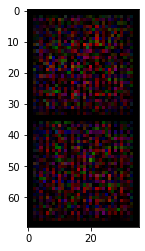

In [14]:
import matplotlib.pyplot as plt
grid_img = torchvision.utils.make_grid(outs, nrow=1)
plt.imshow(grid_img.permute(1, 2, 0))

In [15]:
# see if we can overfit the teacher to a single image
import torch.optim as optim
from tqdm import tqdm
data = next(iter(cifar10_dm.train_dataloader()))
data = data[0][0:2]
#data = data.unsqueeze(0)
criterion = nn.MSELoss() # just to see if everything works
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
ins, _ = generate_ins(2,128)
running_loss = 0
epoch = 0
for i in tqdm(range(1000)):
    # get the inputs; data is a list of [inputs, labels]
    inputs = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = teacher_model(ins)
    loss = criterion(outputs, data)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()

100%|██████████| 1000/1000 [00:53<00:00, 18.66it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


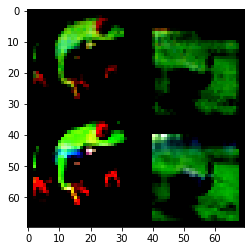

In [16]:
grid_img = torchvision.utils.make_grid(torch.cat([teacher_model(ins),data]), nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))

Okay, the teacher model can learn. Debugging successful!

#Learner
The learner is the same model as the previous standard resnet-18.

In [17]:
# for meta optimization
import sys
if 'higher' not in sys.modules:
  !pip install higher
import higher as higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
class Learner(nn.Module):
    def __init__(self):
        super().__init__()
        self.learner = create_model()
    def forward(self,x):
        return self.learner(x)


The inner loop loss:

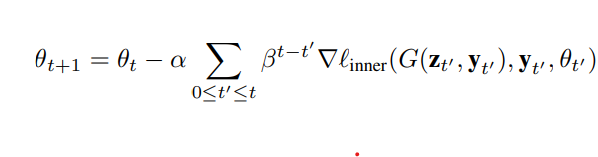

In [19]:
def apply_weight_norm(m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d or type(m) == nn.LazyLinear or type(m) == nn.Linear:
        nn.utils.weight_norm(m)
ler = Learner()
ler.apply(apply_weight_norm)
print(ler.learner.conv1.weight_g.size())


torch.Size([64, 1, 1, 1])


In [20]:
class GTN(LightningModule):
    def __init__(self, latent_dim: int = 128,inner_loop_steps:int=5, lr: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.teacher = Teacher(z_dim=self.hparams.latent_dim,num_classes=10)
        self.learner = Learner()
        
        self.hparams.inner_loop_steps = inner_loop_steps
        self.inner_loss_criterion =  nn.CrossEntropyLoss()
        self.outer_loss_criterion =  nn.CrossEntropyLoss()

        # Important: This property activates manual optimization.
        self.automatic_optimization = False
        self.learning_rate = self.hparams.lr
        
        self.learner_optim_params = nn.Parameter(torch.tensor([0.02, 0.5]), True)

    def forward(self,image):
        return self.learner(image)

    def inner_loss(self, y_pred, y_gt):
        return self.inner_loss_criterion(y_pred,y_gt)
        
    def outer_loss(self, y_pred, y_gt):
        return self.outer_loss_criterion(y_pred,y_gt)

    def inner_loop(self,device,mode,inner_optim, flearner, diffopt):
         # sample noise
        # z also contains the one hot encoded labels!
        z, y_gt = generate_ins(BATCH_SIZE,self.hparams.latent_dim) #add argument for lables to be stable
        z.to(device)
        y_gt.to(device)
        generated_images = self.teacher(z)
        #y_pred = self.learner(self.generated_images)
        y_pred = flearner(self.generated_images)
        loss = self.inner_loss(y_pred,y_gt)
        diffopt.step(loss)

        sample_imgs = generated_images[:6].cpu()
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, 0)
        self.log("%_loss_inner" % mode, loss)
        return flearner, diffopt


    def outer_loop(self,batch, mode="train"):
        device = batch[0].device
        # is this necessary?
        self.teacher.train()
        self.optimizer_teacher.zero_grad()

        inner_optim = optim.SGD(self.learner.parameters(), lr= 0.02, momentum=0.9) # self.learner_lr.item(), momentum=self.learner_momentum.item())
        self.learner.train()
        with higher.innerloop_ctx(self.learner, inner_optim, override={'lr': [self.learner_lr], 'momentum': [self.learner_momentum]}) as (flearner, diffopt):
            for i in range(self.hparams.inner_loop_steps):
                #self.inner_loop(device,mode,inner_optim,flearner, diffopt)
                z, y_gt = generate_ins(BATCH_SIZE,self.hparams.latent_dim) #add argument for lables to be stable
                z = z.to(device)
                y_gt = y_gt.to(device)
                #print(z.device)
                #print(y_gt.device)
                #print(self.teacher.device)
                generated_images = self.teacher(z)
                #print("----------")
                #y_pred = self.learner(self.generated_images)
                y_pred = flearner(generated_images)
                #print(y_pred.get_device())
                loss = self.inner_loss(y_pred,y_gt)
                diffopt.step(loss)

                sample_imgs = generated_images[:6].cpu()
                grid = torchvision.utils.make_grid(sample_imgs)
                #self.logger.experiment.add_image("generated_images", grid, 0)
                self.log("train_loss_inner ", loss, prog_bar=True, logger=True)
            # now on real data
            real_images, target = batch
            y_pred_real = flearner(real_images)# is this the same flearner as previous?
            loss = self.outer_loss(y_pred_real, target)
            self.log("train_loss_outer", loss, prog_bar=True, logger=True)
            loss.backward()

        #print(self.optimizer_teacher.device)
        self.optimizer_teacher.step()
        #print("lr: new", self.learner_lr.item())
        #self.learner_lr = torch.max(self.learner_lr, torch.tensor(0.0005))

    def training_step(self, batch, batch_idx):
        # manual optimiziers https://pytorch-lightning.readthedocs.io/en/latest/common/optimization.html
        #g_opt, d_opt = self.optimizers()
        self.outer_loop(batch)
        #print("Finished Training step")
        return None

    def configure_optimizers(self):
        #lr = self.learning_rate
        #opt_teacher = torch.optim.SGD(self.teacher.parameters(), lr=lr)
        #opt_learner = torch.optim.SGD(self.learner.parameters(), lr=lr)
        self.optimizer_teacher = optim.Adam(self.teacher.parameters(), lr=self.learning_rate)
        self.learner_lr = self.teacher.learner_optim_params[0]
        self.learner_momentum = self.teacher.learner_optim_params[1]
        return None
     
    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self.learner(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")


In [21]:
import pytorch_lightning as pl

In [22]:
run = wandb.init(project="GTN", entity="skylab", reinit=True)


In [25]:
!nvidia-smi

Tue May 24 10:48:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    37W / 250W |  16245MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pl.seed_everything(42)
wandb_logger = WandbLogger()

model = GTN(lr=0.02,inner_loop_steps= 8)
model.datamodule = cifar10_dm
trainer = Trainer(accelerator="cpu",
                     max_epochs=2,
                    logger=wandb_logger,    # W&B integration
                    log_every_n_steps=10,   # set the logging frequency
                    )
trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trai

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/optimizer.py:184: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  "`LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer",

  | Name                 | Type             | Params
----------------------------------------------------------
0 | teacher       

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

In [27]:
run.finish()

epoch,▁▁
test_acc,▁
test_loss,▁
train_loss_inner,▁
train_loss_outer,▁
trainer/global_step,▁█
epoch,0
test_acc,0.1
test_loss,-0.28241
train_loss_inner,2.33991
train_loss_outer,2.30528


In [67]:
wandb.finish()

Exception: ignored